Status: Optimal
Number of sensors placed: 9
Actual Area Coverage: 70.56%


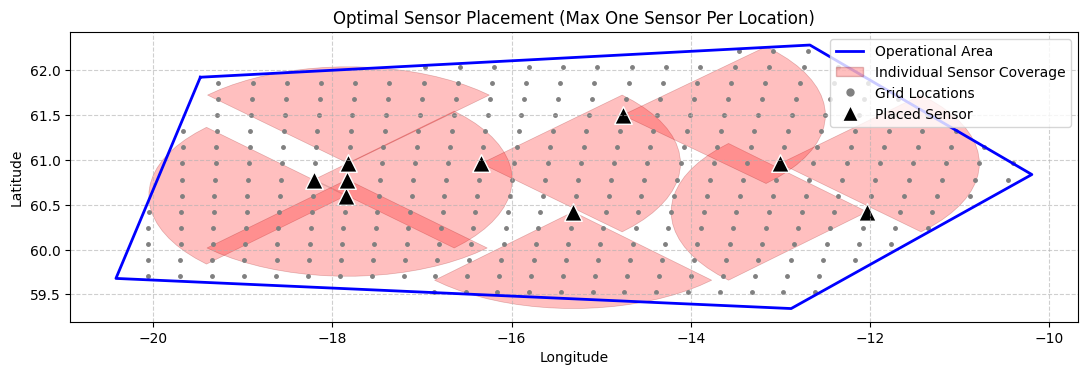

In [4]:
import numpy as np
from shapely.geometry import Polygon, Point, mapping
from shapely.ops import unary_union
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Wedge
import pulp
import json

# --- Step 1: Helper functions ---

def create_fan_polygon(center_lon, center_lat, range_km, orientation_deg, fan_angle_deg):
    EARTH_RADIUS_KM = 6371
    range_deg = (range_km / EARTH_RADIUS_KM) * (180 / np.pi)
    angles = np.linspace(orientation_deg - fan_angle_deg / 2,
                         orientation_deg + fan_angle_deg / 2,
                         20)
    arc_points = []
    for angle in angles:
        d_lat = range_deg * np.cos(np.radians(angle))
        d_lon = range_deg * np.sin(np.radians(angle)) / np.cos(np.radians(center_lat))
        arc_points.append((center_lon + d_lon, center_lat + d_lat))
    fan_points = [(center_lon, center_lat)] + arc_points
    return Polygon(fan_points)

def get_grid_points_in_polygon_km(polygon, resolution_km):
    EARTH_RADIUS_KM = 6371
    min_lon, min_lat, max_lon, max_lat = polygon.bounds
    grid_points = []
    lat_step = (resolution_km / EARTH_RADIUS_KM) * (180 / np.pi)
    current_lat = min_lat
    while current_lat <= max_lat:
        deg_lon_dist_km = (np.pi / 180) * EARTH_RADIUS_KM * np.cos(np.radians(current_lat))
        lon_step = resolution_km / deg_lon_dist_km if deg_lon_dist_km > 0 else max_lon - min_lon + 1
        current_lon = min_lon
        while current_lon <= max_lon:
            point = Point(current_lon, current_lat)
            if polygon.contains(point):
                grid_points.append(point)
            current_lon += lon_step
        current_lat += lat_step
    return grid_points

# --- Step 2: Define problem parameters ---

operational_area = Polygon([
    (-19.472290, 61.924296), (-12.670804, 62.283310),
    (-10.194365, 60.838503), (-12.880080, 59.343106),
    (-20.414034, 59.679341),
])

locations = get_grid_points_in_polygon_km(operational_area, 20)
num_locations = len(locations)
sensor_range_km = 120
sensor_fov_deg = 90
configurations = {
    'N': 0, 
    'NE': 45,
    'E': 90, 
    'SE': 135,
    'S': 180, 
    'SW': 225,
    'W': 270,
    'NW': 315,
}
config_keys = list(configurations.keys())
num_configs = len(configurations)
max_sensors = 10
coverage_requirement = 0.70
fan_opacity = 0.25

# --- Step 3: Pre-calculate Covers matrix ---

covers = np.zeros((num_locations, num_locations, num_configs))
for l_idx, l_point in enumerate(locations):
    for j_idx, j_key in enumerate(config_keys):
        fan_poly = create_fan_polygon(l_point.x, l_point.y, sensor_range_km, configurations[j_key], sensor_fov_deg)
        for i_idx, i_point in enumerate(locations):
            if fan_poly.contains(i_point):
                covers[i_idx, l_idx, j_idx] = 1

# --- Step 4: Build and solve the optimization problem ---

prob = pulp.LpProblem("Sensor_Placement", pulp.LpMinimize)
place_vars = pulp.LpVariable.dicts("Place", (range(num_locations), range(num_configs)), cat='Binary')
is_covered_vars = pulp.LpVariable.dicts("IsCovered", range(num_locations), cat='Binary')

# Objective: Minimize the total number of sensors
prob += pulp.lpSum(place_vars[l][j] for l in range(num_locations) for j in range(num_configs)), "Total_Sensors"

# Constraint 1: Don't exceed the maximum number of available sensors
prob += pulp.lpSum(place_vars[l][j] for l in range(num_locations) for j in range(num_configs)) <= max_sensors

# Constraint 2: Achieve the required percentage of grid point coverage
prob += pulp.lpSum(is_covered_vars[i] for i in range(num_locations)) >= coverage_requirement * num_locations

# Constraint 3: Link the is_covered variable to the placement variables
for i in range(num_locations):
    prob += pulp.lpSum(covers[i, l, j] * place_vars[l][j] for l in range(num_locations) for j in range(num_configs)) >= is_covered_vars[i]

# Constraint 4: Ensure at most one sensor is placed at any given location
for l in range(num_locations):
    prob += pulp.lpSum(place_vars[l][j] for j in range(num_configs)) <= 1, f"One_Sensor_Per_Location_{l}"

# Solve the problem
prob.solve()

# --- Step 5: Process results and calculate area coverage ---

print(f"Status: {pulp.LpStatus[prob.status]}")
print(f"Number of sensors placed: {int(pulp.value(prob.objective))}")

placed_sensors_polygons = []
placed_sensors_info = []
for l in range(num_locations):
    for j in range(num_configs):
        if pulp.value(place_vars[l][j]) == 1:
            loc = locations[l]
            conf_key = config_keys[j]
            heading = configurations[conf_key]
            fan = create_fan_polygon(loc.x, loc.y, sensor_range_km, heading, sensor_fov_deg)
            placed_sensors_polygons.append(fan)
            placed_sensors_info.append({'location': loc, 'config_name': conf_key})

total_coverage_geom = unary_union(placed_sensors_polygons)
final_covered_area = operational_area.intersection(total_coverage_geom)
area_coverage_percentage = (final_covered_area.area / operational_area.area) * 100
print(f"Actual Area Coverage: {area_coverage_percentage:.2f}%")

# --- Step 6: Improved Plotting ---

fig, ax = plt.subplots(figsize=(13, 13))
ax.set_aspect('equal')
px, py = operational_area.exterior.xy
ax.plot(px, py, 'b-', linewidth=2, label='Operational Area')

for fan_poly in placed_sensors_polygons:
    fan_x, fan_y = fan_poly.exterior.xy
    ax.fill(fan_x, fan_y, alpha=fan_opacity, fc='red', ec='darkred', linewidth=0.5)

ax.scatter([p.x for p in locations], [p.y for p in locations], c='gray', marker='.', s=25, label='Grid Locations')
ax.scatter([s['location'].x for s in placed_sensors_info], 
           [s['location'].y for s in placed_sensors_info], 
           c='black', edgecolor='white', s=160, marker='^', label='Placed Sensor')

legend_elements = [
    plt.Line2D([0], [0], color='b', lw=2, label='Operational Area'),
    Patch(facecolor='red', alpha=fan_opacity, edgecolor='darkred', label=f'Individual Sensor Coverage'),
    plt.Line2D([0], [0], marker='.', color='gray', label='Grid Locations', markersize=10, linestyle='None'),
    plt.Line2D([0], [0], marker='^', color='black', label='Placed Sensor', markersize=12, markerfacecolor='black', markeredgecolor='white', linestyle='None')
]
ax.legend(handles=legend_elements, loc='upper right')
ax.set_title('Optimal Sensor Placement (Max One Sensor Per Location)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [5]:

def export_to_geojson(filename, op_area, placed_sensors, sensor_params):
    """
    Exports the sensor placement results to a GeoJSON file.

    Args:
        filename (str): The path for the output GeoJSON file.
        op_area (shapely.Polygon): The operational area polygon.
        placed_sensors (list): A list of dictionaries, where each dictionary
                               contains info about a placed sensor (location, config_name).
        sensor_params (dict): A dictionary with sensor parameters like
                              'range_km', 'fov_deg', and 'configurations'.
    """
    features = []

    # 1. Add the Operational Area Feature
    op_area_feature = {
        "type": "Feature",
        "geometry": mapping(op_area),
        "properties": {
            "name": "Operational Area",
            "type": "boundary"
        }
    }
    features.append(op_area_feature)

    # 2. Add a Feature for each Sensor (Point) and its Coverage Area (Polygon)
    for i, sensor in enumerate(placed_sensors):
        loc = sensor['location']
        conf_name = sensor['config_name']
        heading = sensor_params['configurations'][conf_name]
        
        # Create the coverage fan polygon
        fan_poly = create_fan_polygon(
            center_lon=loc.x,
            center_lat=loc.y,
            range_km=sensor_params['range_km'],
            orientation_deg=heading,
            fan_angle_deg=sensor_params['fov_deg']
        )

        # Add Sensor Point Feature
        sensor_point_feature = {
            "type": "Feature",
            "geometry": mapping(loc),
            "properties": {
                "type": "Sensor Placement",
                "id": i,
                "orientation": conf_name,
            }
        }
        features.append(sensor_point_feature)

        # Add Coverage Area Feature
        coverage_area_feature = {
            "type": "Feature",
            "geometry": mapping(fan_poly),
            "properties": {
                "type": "Coverage Area",
                "sensor_id": i,
                "orientation": conf_name,
                "fill":"#FF0000",
                "fill-opacity": 0.5
            }
        }
        features.append(coverage_area_feature)

    # Assemble the final GeoJSON FeatureCollection
    geojson_output = {
        "type": "FeatureCollection",
        "features": features
    }

    # Write the object to a file
    with open(filename, 'w') as f:
        json.dump(geojson_output, f, indent=2)
    
    print(f"Successfully exported data to {filename}")

In [6]:


output_filename = "sensor_placement.geojson"

sensor_parameters = {
    'range_km': sensor_range_km,
    'fov_deg': sensor_fov_deg,
    'configurations': configurations
}

# 2. Call the export function
export_to_geojson(
    filename=output_filename,
    op_area=operational_area,
    placed_sensors=placed_sensors_info,
    sensor_params=sensor_parameters
)


Successfully exported data to sensor_placement.geojson
